In [1]:
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [1]:
!pip install -U pip
!pip install -U -r requirements.txt
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 2.1 MB 13.0 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 23.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.2/342.2 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 23.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 23.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 23.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.9/52.9 MB 23.9 MB/s eta 0:00:00

In [1]:
from transformers import (
    BertForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
import datasets
from datasets import load_metric
import numpy as np
from pathlib import Path
import os
import argparse
from huforpred.bert.utils import compute_metrics

In [4]:
training_data_path = Path('/datasets/finhubert_filter')

labeled_data = datasets.Dataset.from_parquet(
    {
        "train": (training_data_path / "labelled_train_gyenes.parquet").as_posix(),
        "validation": (training_data_path / "labelled_test_gyenes.parquet").as_posix(),
        "test": (training_data_path / "labelled_test.parquet").as_posix(),
    },
    features=datasets.Features(
        {"text": datasets.Value("string"), "label": datasets.ClassLabel(num_classes=2)}
    ),
)

Using custom data configuration default-0023b6ca1bb4b7d6
Reusing dataset parquet (/root/.cache/huggingface/datasets/parquet/default-0023b6ca1bb4b7d6/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
model_name = "papsebestyen/hubert-base-cc-finetuned-forum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=2,
    #attention_probs_dropout_prob=0.3,
    #hidden_dropout_prob=0.3,
)


def preprocess_function(examples):
    return tokenizer(
        examples["text"], padding="max_length", truncation=True, max_length=512
    )


tokenized_data = labeled_data.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loading file https://huggingface.co/papsebestyen/hubert-base-cc-finetuned-forum/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/b16f0a18c599b551464c586c0b96b1a978cd8c84de9527cb43a5de35d90290e7.dd0380e6ef41dcfd523f8aa0fff30e0a3cd32404089a9e177004c7af42b35735
loading file https://huggingface.co/papsebestyen/hubert-base-cc-finetuned-forum/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/dbb51c7fc96d99548e4ebda2556e2dccdc396a5cce93eeba4fa189e0e191af77.828a0f4339e10fc1b77efae710889bcc2d75d7c49e48d4d5c6ff945ed96c27b9
loading file https://huggingface.co/papsebestyen/hubert-base-cc-finetuned-forum/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/papsebestyen/hubert-base-cc-finetuned-forum/resolve/main/special_tokens_map.json from cache at /root/.cache/huggingface/transformers/a2c12af4e743fb6398dab8d983db0dc668f5ddad8d4f53f56cb7cdc51dc21fbb.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd806

In [6]:
import json

In [7]:
tuned_config = json.loads(Path('best_params_gyenes_v1.json').read_text())

In [8]:
from huggingface_hub import notebook_login

notebook_login()

In [9]:
!git --version
!apt-get install git-lfs
!git-lfs install

git version 2.25.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.
Updated git hooks.
Git LFS initialized.


In [14]:
batch_size = 64
logging_steps = len(tokenized_data["train"]) // batch_size


training_args = TrainingArguments(
    output_dir='hubert-base-cc-finance-filter',
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    push_to_hub=True,
    logging_steps = logging_steps,
    auto_find_batch_size = True,
    fp16=True,
    **tuned_config
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/notebooks/hubert-base-cc-finance-filter is already a clone of https://huggingface.co/papsebestyen/hubert-base-cc-finance-filter. Make sure you pull the latest changes with `repo.git_pull()`.
Using amp half precision backend


In [15]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 5
  Instantaneous batch size per device = 60
  Total train batch size (w. parallel, distributed & accumulation) = 60
  Gradient Accumulation steps = 1
  Total optimization steps = 70
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSe

Epoch,Training Loss,Validation Loss,F1
1,0.571700,0.691788,0.624000
2,0.410400,0.423628,0.711864
3,0.312400,0.600147,0.745098
4,0.140400,0.538848,0.767123
5,0.130500,0.538848,0.767123


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64
Saving model checkpoint to hubert-base-cc-finance-filter/checkpoint-54
Configuration saved in hubert-base-cc-finance-filter/checkpoint-54/config.json
Model weights saved in hubert-base-cc-finance-filter/checkpoint-54/pytorch_model.bin
tokenizer config file saved in hubert-base-cc-finance-filter/checkpoint-54/tokenizer_config.json
Special tokens file saved in hubert-base-cc-finance-filter/checkpoint-54/special_tokens_map.json
tokenizer config file saved in hubert-base-cc-finance-filter/tokenizer_config.json
Special tokens file saved in hubert-base-cc-finance-filter/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argume

TrainOutput(global_step=270, training_loss=0.3162301103274027, metrics={'train_runtime': 1436.3011, 'train_samples_per_second': 2.785, 'train_steps_per_second': 0.188, 'total_flos': 1052444221440000.0, 'train_loss': 0.3162301103274027, 'epoch': 5.0})

In [16]:
trainer.push_to_hub()

Saving model checkpoint to hubert-base-cc-finance-filter
Configuration saved in hubert-base-cc-finance-filter/config.json
Model weights saved in hubert-base-cc-finance-filter/pytorch_model.bin
tokenizer config file saved in hubert-base-cc-finance-filter/tokenizer_config.json
Special tokens file saved in hubert-base-cc-finance-filter/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 32.0k/422M [00:00<?, ?B/s]

Upload file runs/May19_18-59-01_ne49ze6z08/events.out.tfevents.1652986748.ne49ze6z08.10943.4: 100%|##########|…

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/papsebestyen/hubert-base-cc-finance-filter
   696fbe5..eeff528  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'F1', 'type': 'f1', 'value': 0.767123287671233}]}
remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/papsebestyen/hubert-base-cc-finance-filter
   eeff528..05818d1  main -> main



'https://huggingface.co/papsebestyen/hubert-base-cc-finance-filter/commit/eeff528232829eac92a9b26fc6eb63fcc3ce4a14'

In [17]:
predictions = trainer.predict(tokenized_data['test'])

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 400
  Batch size = 64


In [18]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

In [20]:
print(classification_report(predictions.label_ids, preds, digits=5))

              precision    recall  f1-score   support

           0    0.92827   0.81181   0.86614       271
           1    0.68712   0.86822   0.76712       129

    accuracy                        0.83000       400
   macro avg    0.80769   0.84001   0.81663       400
weighted avg    0.85050   0.83000   0.83421       400



In [21]:
import pandas as pd

In [29]:
pd.DataFrame({'text': labeled_data['test']['text'], 'prediction': preds, 'true_label': predictions.label_ids}).to_excel('preds.xlsx')

NameError: name 'pd' is not defined

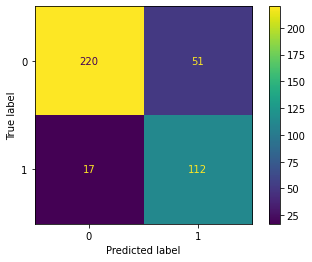

In [23]:
ConfusionMatrixDisplay(confusion_matrix(predictions.label_ids, preds)).plot()

In [37]:
def my_hp_space_ray(trial):
    from ray import tune

    return {
        "learning_rate": tune.loguniform(1e-5, 5e-5),
        "per_gpu_batch_size": tune.choice([4, 8, 16, 32, 64]),
        "warmup_steps": tune.choice(range(0, 500)),
        "weight_decay": tune.loguniform(0.01, 0.3),
        "num_epochs": tune.choice(range(2, 5)),
    }

In [17]:
del model, trainer

In [3]:
import torch
print(torch.cuda.memory_summary())